In [46]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from overcomplete.sae import TopKSAE, train_sae
import pandas as pd
from scipy import stats

In [5]:
train_path = "./logs/activation.pt"
ckpt = torch.load(train_path)

fc1 = ckpt["fc1"]
fc1_activations = ckpt["fc1_activations"]
labels = ckpt["labels"]

dataloader = torch.utils.data.DataLoader(TensorDataset(fc1), batch_size=1024, shuffle=True)

/tmp/ipykernel_2158724/997568700.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(train_path)


### Learning Rate: 5e-4

In [6]:
sae = TopKSAE(fc1.shape[-1], nb_concepts=256, top_k=12, device='cuda')

dataloader = torch.utils.data.DataLoader(TensorDataset(fc1), batch_size=1024, shuffle=True)
optimizer = torch.optim.Adam(sae.parameters(), lr=5e-4)

def criterion(x, x_hat, pre_codes, codes, dictionary):
  mse = (x - x_hat).square().mean()
  return mse

logs = train_sae(sae, dataloader, criterion, optimizer, nb_epochs=15, device='cuda')

Epoch[1/15], Loss: 13.9528, R2: 0.0559, L0: 12.0000, Dead Features: 53.5%, Time: 37.2475 seconds
Epoch[2/15], Loss: 3.9997, R2: 0.7292, L0: 12.0000, Dead Features: 87.5%, Time: 37.2609 seconds
Epoch[3/15], Loss: 1.7457, R2: 0.8818, L0: 12.0000, Dead Features: 56.6%, Time: 36.4445 seconds
Epoch[4/15], Loss: 0.9144, R2: 0.9381, L0: 12.0000, Dead Features: 48.0%, Time: 37.7723 seconds
Epoch[5/15], Loss: 0.6527, R2: 0.9558, L0: 12.0000, Dead Features: 65.2%, Time: 38.8367 seconds
Epoch[6/15], Loss: 0.5137, R2: 0.9652, L0: 12.0000, Dead Features: 69.1%, Time: 41.0779 seconds
Epoch[7/15], Loss: 0.4198, R2: 0.9716, L0: 12.0000, Dead Features: 77.3%, Time: 37.0678 seconds
Epoch[8/15], Loss: 0.3555, R2: 0.9759, L0: 12.0000, Dead Features: 78.5%, Time: 33.6662 seconds
Epoch[9/15], Loss: 0.3113, R2: 0.9789, L0: 12.0000, Dead Features: 74.6%, Time: 36.2314 seconds
Epoch[10/15], Loss: 0.2718, R2: 0.9816, L0: 11.9999, Dead Features: 73.8%, Time: 30.3184 seconds
Epoch[11/15], Loss: 0.2356, R2: 0.9840

### Learning Rate: 1e-3 and Dead Feature Constraint: Improved drastically

In [12]:
sae = TopKSAE(fc1.shape[-1], nb_concepts=256, top_k=12, device='cuda')
optimizer = torch.optim.Adam(sae.parameters(), lr=1e-3)
logs = train_sae(sae, dataloader, criterion, optimizer, nb_epochs=30, device='cuda')

Epoch[1/30], Loss: 9.1610, R2: 0.3796, L0: 12.0000, Dead Features: 0.0%, Time: 40.1260 seconds
Epoch[2/30], Loss: 1.3573, R2: 0.9080, L0: 12.0000, Dead Features: 7.0%, Time: 33.0065 seconds
Epoch[3/30], Loss: 0.5675, R2: 0.9616, L0: 12.0000, Dead Features: 2.0%, Time: 39.2235 seconds
Epoch[4/30], Loss: 0.4165, R2: 0.9718, L0: 12.0000, Dead Features: 0.0%, Time: 36.4863 seconds
Epoch[5/30], Loss: 0.3409, R2: 0.9769, L0: 12.0000, Dead Features: 0.0%, Time: 38.0045 seconds
Epoch[6/30], Loss: 0.2857, R2: 0.9806, L0: 12.0000, Dead Features: 0.0%, Time: 42.1555 seconds
Epoch[7/30], Loss: 0.2467, R2: 0.9833, L0: 12.0000, Dead Features: 0.0%, Time: 43.3808 seconds
Epoch[8/30], Loss: 0.2181, R2: 0.9852, L0: 12.0000, Dead Features: 0.0%, Time: 33.9246 seconds
Epoch[9/30], Loss: 0.1955, R2: 0.9868, L0: 12.0000, Dead Features: 0.0%, Time: 41.8427 seconds
Epoch[10/30], Loss: 0.1794, R2: 0.9879, L0: 12.0000, Dead Features: 0.0%, Time: 41.8815 seconds
Epoch[11/30], Loss: 0.1671, R2: 0.9887, L0: 12.00

In [15]:
sae = sae.eval()

with torch.no_grad():
  pre_codes, codes = sae.encode(fc1.to('cuda'))

In [21]:
activations = codes.cpu()

activations_T = activations.T 

max_vals = activations_T.max(dim=1).values
min_vals = activations_T.min(dim=1).values

df = pd.DataFrame({
    'neuron_id': range(activations_T.shape[0]),
    'max_activation': max_vals.numpy(),
    'min_activation': min_vals.numpy()
})

In [31]:
df_filter = df[df.max_activation != 0]
df_filter.shape

(149, 3)

In [34]:
filtered_labels_per_active_neuron = {}

for _, row in df_filter.iterrows():
    neuron_id = int(row['neuron_id'])
    max_val = row['max_activation']
    lower_bound = max_val / 2
    upper_bound = max_val

    mask = (activations[:, neuron_id] >= lower_bound) & (activations[:, neuron_id] <= upper_bound)

    filtered_labels = labels[mask]

    filtered_labels_per_active_neuron[neuron_id] = filtered_labels.tolist()

summary_rows = []

for neuron_id, label_list in filtered_labels_per_active_neuron.items():
    label_counts = pd.Series(label_list).value_counts()
    row = {'neuron_id': neuron_id}
    for class_label in range(10):
        row[class_label] = label_counts.get(class_label, 0)

    summary_rows.append(row)
summary_df = pd.DataFrame(summary_rows)

In [36]:

[18, -150, [18, 0 20] 20] =
merged_df = pd.merge(df_filter, summary_df, on='neuron_id', how='inner')
merged_df

,neuron_id,max_activation,min_activation,0,1,2,3,4,5,6,7,8,9
0,1,1.096978,0.0,16,0,0,0,9,1,120,0,3,2
1,2,0.944608,0.0,0,0,0,0,1,1,0,1,0,4
2,3,20.419756,0.0,1996,0,0,6,49,10,673,22,22,141
3,5,36.266994,0.0,3477,9,3484,1199,1,586,284,0,1118,17
4,6,1.039241,0.0,0,1,0,0,2,0,0,15,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,245,14.958872,0.0,329,2,2,30,0,561,185,0,49,0
145,246,1.173136,0.0,0,0,0,0,8,3,1,3,1,1
146,252,1.351995,0.0,0,0,0,0,0,0,0,0,1,0
147,253,6.648617,0.0,0,0,0,0,400,0,3,1,0,11


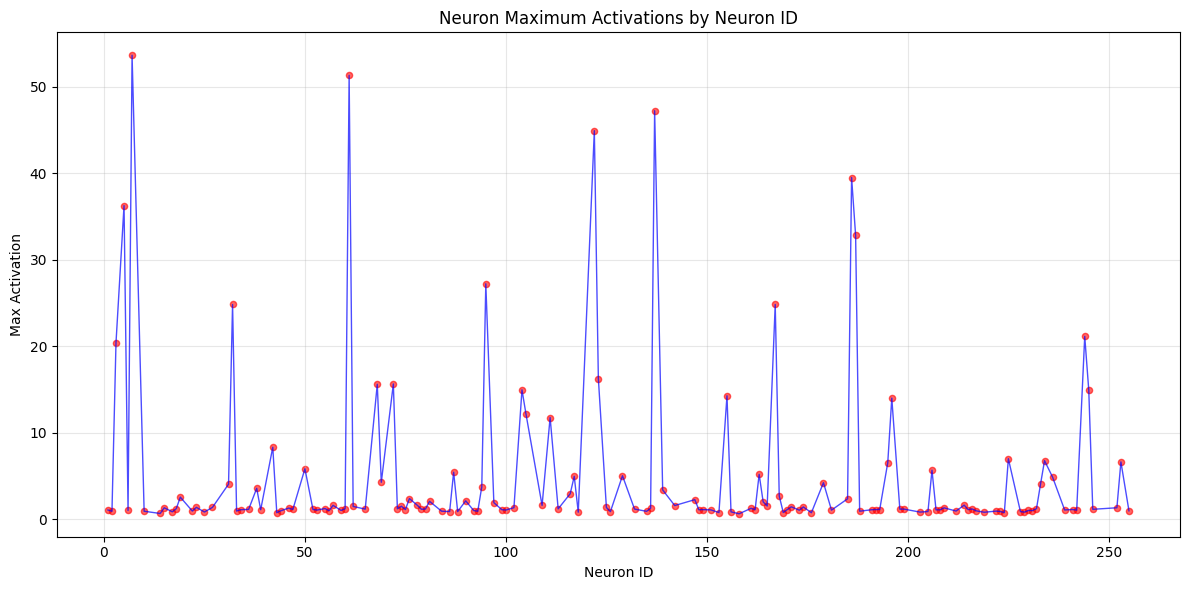

In [72]:

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(merged_df['neuron_id'], merged_df['max_activation'], 'b-', linewidth=1, alpha=0.7)
plt.scatter(merged_df['neuron_id'], merged_df['max_activation'], c='red', s=20, alpha=0.6)

# Customize the plot
plt.xlabel('Neuron ID')
plt.ylabel('Max Activation')
plt.title('Neuron Maximum Activations by Neuron ID')
plt.grid(True, alpha=0.3)

# Optional: Add some styling
plt.tight_layout()

plt.show()


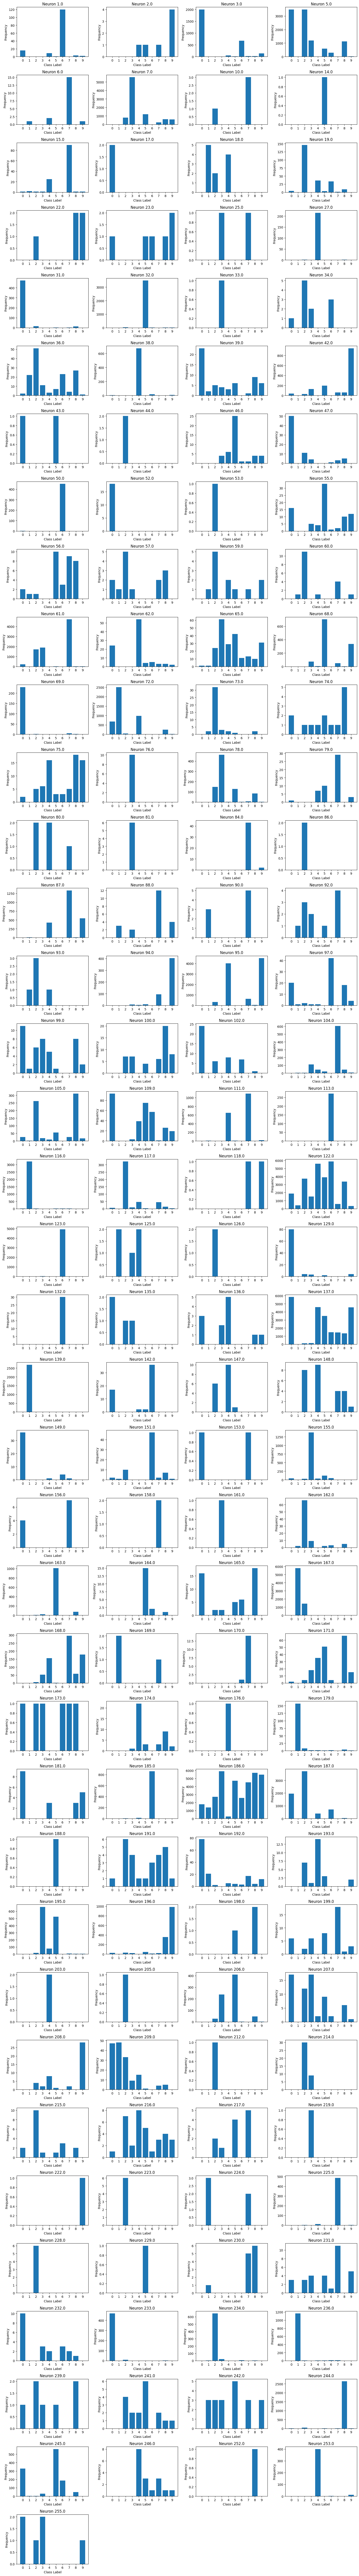

In [56]:
n_neurons = merged_df.shape[0]

n_cols = 4
n_rows = (n_neurons + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))

axes = axes.flatten()

label_cols = list(range(10))  

for idx, row in merged_df.iterrows():
    neuron_id = row['neuron_id']
    label_counts = row[label_cols]

    ax = axes[idx]
    ax.bar(label_cols, label_counts)
    ax.set_title(f'Neuron {neuron_id}')
    ax.set_xticks(label_cols)
    ax.set_xlabel('Class Label')
    ax.set_ylabel('Frequency')
 
for ax in axes[n_neurons:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [40]:
merged_df

,neuron_id,max_activation,min_activation,0,1,2,3,4,5,6,7,8,9
0,1,1.096978,0.0,16,0,0,0,9,1,120,0,3,2
1,2,0.944608,0.0,0,0,0,0,1,1,0,1,0,4
2,3,20.419756,0.0,1996,0,0,6,49,10,673,22,22,141
3,5,36.266994,0.0,3477,9,3484,1199,1,586,284,0,1118,17
4,6,1.039241,0.0,0,1,0,0,2,0,0,15,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,245,14.958872,0.0,329,2,2,30,0,561,185,0,49,0
145,246,1.173136,0.0,0,0,0,0,8,3,1,3,1,1
146,252,1.351995,0.0,0,0,0,0,0,0,0,0,1,0
147,253,6.648617,0.0,0,0,0,0,400,0,3,1,0,11


In [62]:
def calculate_neuron_metrics(df):

    class_cols = [i for i in range(10)]
    class_frequencies = df[class_cols].values
    
    metrics = []
    
    for idx, row in df.iterrows():
        neuron_id = row['neuron_id']
        freqs = class_frequencies[idx]
        
        if freqs.sum() > 0:
            freqs = freqs / freqs.sum()
        else:
            freqs = np.ones(10) / 10  
        
        max_freq = np.max(freqs)
        other_freqs = freqs[freqs != max_freq]
        mean_other = np.mean(other_freqs) if len(other_freqs) > 0 else 0
        csi = (max_freq - mean_other) / max_freq if max_freq > 0 else 0
        
        freqs_safe = freqs + 1e-10
        entropy = -np.sum(freqs_safe * np.log(freqs_safe))
        max_entropy = np.log(10)  
        entropy_purity = 1 - (entropy / max_entropy)
        
        gini = 1 - np.sum(freqs**2)
        gini_purity = 1 - gini
        
        sorted_freqs = np.sort(freqs)[::-1]  
        top2_ratio = sorted_freqs[1] / sorted_freqs[0] if sorted_freqs[0] > 0 else 0
        
        threshold = 0.1
        active_classes = np.sum(freqs > threshold)
        
        dominant_class = np.argmax(freqs)
        dominant_freq = max_freq
                
        if csi > 0.7:
            classification = "Pure"
        elif csi > 0.3:
            classification = "Compositional"
        else:
            classification = "Distributed"
        
        metrics.append({
            'neuron_id': neuron_id,
            'max_activation': row['max_activation'],
            'min_activation': row['min_activation'],
            'dominant_class': dominant_class,
            'dominant_frequency': dominant_freq,
            'csi': csi,
            'entropy_purity': entropy_purity,
            'gini_purity': gini_purity,
            'top2_ratio': top2_ratio,
            'active_classes_count': active_classes,
            'classification': classification,
            'class_frequencies': class_frequencies[idx] 
        })
    
    return pd.DataFrame(metrics)

In [64]:
metrics_df = calculate_neuron_metrics(merged_df)

In [100]:
metrics_df[(metrics_df.max_activation > 5) & (metrics_df.classification == 'Compositional')]

,neuron_id,max_activation,min_activation,dominant_class,dominant_frequency,csi,entropy_purity,gini_purity,top2_ratio,active_classes_count,classification,class_frequencies
71,122.0,44.926624,8.894089,6,0.216207,0.597201,0.126799,0.152618,0.952893,5,Compositional,"[1863, 421, 3729, 1518, 5583, 3883, 5859, 576,..."
79,137.0,47.232834,0.000000,0,0.253618,0.673008,0.196345,0.178017,0.785604,4,Compositional,"[5835, 1, 118, 130, 4584, 3504, 1479, 1462, 13..."
106,186.0,39.511433,0.000000,3,0.168157,0.450352,0.077735,0.129909,0.969254,5,Compositional,"[1766, 1391, 2713, 5887, 243, 4729, 2558, 4526..."


In [104]:
metrics_df[metrics_df.max_activation > 10]

,neuron_id,max_activation,min_activation,dominant_class,dominant_frequency,csi,entropy_purity,gini_purity,top2_ratio,active_classes_count,classification,class_frequencies
2,3.0,20.419756,0.000000,0,0.683796,0.948619,0.600874,0.523479,0.337174,2,Pure,"[1996, 0, 0, 6, 49, 10, 673, 22, 22, 141]"
3,5.0,36.266994,0.000000,2,0.342408,0.786612,0.343941,0.264074,0.997991,4,Pure,"[3477, 9, 3484, 1199, 1, 586, 284, 0, 1118, 17]"
5,7.0,53.643341,0.000000,3,0.618121,0.931355,0.460163,0.417382,0.217626,2,Pure,"[1, 2, 801, 5560, 6, 1210, 0, 236, 603, 576]"
17,32.0,24.842321,0.000000,5,0.981164,0.997867,0.946812,0.962768,0.006590,1,Pure,"[4, 0, 23, 1, 0, 3490, 17, 0, 11, 11]"
36,61.0,51.317406,0.000000,7,0.547187,0.908052,0.507307,0.387651,0.400595,3,Pure,"[213, 5, 1711, 1886, 1, 25, 0, 4708, 27, 28]"
39,68.0,15.621672,0.000000,5,0.601542,0.926401,0.564279,0.450133,0.477208,2,Pure,"[0, 0, 0, 74, 5, 702, 0, 50, 1, 335]"
41,72.0,15.658404,0.000000,1,0.560501,0.912876,0.490008,0.388624,0.391460,3,Pure,"[683, 2506, 37, 1, 981, 0, 8, 3, 241, 11]"
58,95.0,27.234077,0.000000,9,0.473956,0.876678,0.548793,0.407870,0.889432,2,Pure,"[0, 1, 320, 5, 4006, 0, 0, 629, 38, 4504]"
63,104.0,14.979823,0.000000,7,0.715640,0.955850,0.558716,0.536034,0.183775,2,Pure,"[2, 3, 5, 111, 46, 22, 0, 604, 45, 6]"
64,105.0,12.171151,0.000000,8,0.429363,0.852330,0.388864,0.324664,0.841935,2,Pure,"[26, 1, 261, 18, 9, 55, 0, 25, 310, 17]"


In [91]:
def get_neuron_ids_by_class(df):
    
    class_neurons = {i: [] for i in range(10)}
    
    for idx, row in df.iterrows():
        frequencies = row['class_frequencies']
        
        for class_num in range(10):
            if class_num < len(frequencies) and frequencies[class_num] > 0:
                class_neurons[class_num].append(int(row['neuron_id']))
    
    return class_neurons

neuron_ids_by_class = get_neuron_ids_by_class(df)

for class_num in range(10):
    print(f"Class {class_num}: {neuron_ids_by_class[class_num]}")

Class 0: [3, 5, 7, 32, 42, 50, 61, 72, 104, 105, 122, 123, 129, 137, 155, 163, 186, 187, 196, 234, 244, 245]
Class 1: [5, 7, 42, 61, 72, 87, 95, 104, 105, 111, 122, 137, 155, 167, 186, 187, 195, 234, 245]
Class 2: [5, 7, 32, 42, 61, 72, 87, 95, 104, 105, 122, 123, 129, 137, 155, 163, 167, 186, 187, 195, 196, 206, 225, 234, 244, 245]
Class 3: [3, 5, 7, 32, 42, 61, 68, 72, 87, 95, 104, 105, 122, 123, 129, 137, 155, 163, 167, 186, 187, 195, 196, 206, 234, 245]
Class 4: [3, 5, 7, 42, 61, 68, 72, 87, 95, 104, 105, 111, 122, 123, 137, 155, 167, 186, 187, 195, 196, 225, 253]
Class 5: [3, 5, 7, 32, 42, 61, 68, 87, 104, 105, 111, 122, 123, 129, 137, 155, 163, 167, 186, 187, 195, 196, 206, 244, 245]
Class 6: [3, 5, 32, 50, 72, 122, 123, 137, 155, 163, 167, 186, 187, 196, 206, 234, 245, 253]
Class 7: [3, 7, 42, 61, 68, 72, 87, 95, 104, 105, 111, 122, 137, 155, 163, 167, 186, 187, 195, 196, 225, 244, 253]
Class 8: [3, 5, 7, 32, 42, 61, 68, 72, 87, 95, 104, 105, 122, 137, 163, 167, 186, 187, 195, 1

In [101]:
class FuzzyNeuronClassifier:
    def __init__(self, neuron_ids_by_class, threshold=0.7):
        self.neuron_ids_by_class = neuron_ids_by_class
        self.threshold = threshold
    
    def predict_single(self, active_neurons):
        active_set = set(active_neurons)
        
        best_class = -1
        best_match_ratio = 0
        
        for class_num, class_neurons in self.neuron_ids_by_class.items():
            if len(class_neurons) == 0:
                continue
                
            class_set = set(class_neurons)
            intersection = active_set.intersection(class_set)
            match_ratio = len(intersection) / len(class_set)
            
            if match_ratio >= self.threshold and match_ratio > best_match_ratio:
                best_match_ratio = match_ratio
                best_class = class_num
        
        return best_class, best_match_ratio
    
    def predict_batch(self, codes, activation_threshold=0.1):
        predictions = []
        match_ratios = []
        
        for i in range(codes.shape[0]):
            active_neurons = torch.where(codes[i] > activation_threshold)[0].cpu().numpy()
            
            pred_class, match_ratio = self.predict_single(active_neurons)
            predictions.append(pred_class)
            match_ratios.append(match_ratio)
        
        return np.array(predictions), np.array(match_ratios)

classifier = FuzzyNeuronClassifier(neuron_ids_by_class, threshold=0.6)

predictions, match_ratios = classifier.predict_batch(codes, activation_threshold=0.1)

if 'labels' in locals():
    true_labels = labels.cpu().numpy()
    
    valid_predictions = predictions != -1
    
    if valid_predictions.sum() > 0:
        accuracy = (predictions[valid_predictions] == true_labels[valid_predictions]).mean()        
        print(f"Accuracy: {accuracy:.3f}")
    else:
        print("No valid predictions made")

unique_preds, counts = np.unique(predictions, return_counts=True)
print(f"\nPrediction distribution:")
for pred, count in zip(unique_preds, counts):
    if pred == -1:
        print(f"  No prediction: {count}")
    else:
        print(f"  Class {pred}: {count}")


Accuracy: 0.222

Prediction distribution:
  No prediction: 58235
  Class 1: 1389
  Class 6: 376
